# US Name
Model estimate Estimate pollution abatement equipment and internal finance


# Description

None

# Metadata

- Key: 317_Financial_dependency_pollution
- Epic: Models
- US: Evaluate econometrics model
- Task tag: #econometrics-strategy, #pollution-abatement-equipment, #training-Financial-dependency-pollution
- Analytics reports: 

# Input

## Table/file

**Name**

None

**Github**

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_train_evaluate/00_estimate_fin_ratio/07_pollution_abatement_equation.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'environment'
table = 'fin_dep_pollution_baseline_city'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    WHERE 
      year in (
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      ) 
      AND 
      lag_current_ratio > 0 
      AND
      lag_cashflow_to_tangible > 0 
      AND 
      tfp_cit > 0
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
    .sort_values(by = ['geocode4_corr','ind2', 'year'])
    .assign(
        tso2_eq_output = lambda x: (x['tdso2_equip'])/(x['output']/1000),
        tso2_eq_output_1 = lambda x: (x['tdso2_equip']+1)/(x['output']/1000),
        lag_equipment = lambda x: x.groupby(['geocode4_corr','ind2'])['tdso2_equip'].transform("shift"),
        gross_change = lambda x: x['tdso2_equip'] - x['lag_equipment'],
        gross_change_output = lambda x: (x['tdso2_equip'] - x['lag_equipment'])/(x['output']/1000),
    )
          .assign(
          constraint = lambda x: x['credit_constraint'] > -0.47,
          std_eq_ind =lambda x: 
              x.groupby(['year', 'ind2'])['tso2_eq_output_1'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq_c =lambda x: 
              x.groupby(['year', 'geocode4_corr'])['tso2_eq_output_1'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq_year =lambda x: 
              x.groupby(['year'])['tso2_eq_output_1'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq =lambda x: (x['tso2_eq_output_1']-x['tso2_eq_output_1'].min())/(
              x['tso2_eq_output_1'].max()-x['tso2_eq_output_1'].min()),
        
         std_eq_ind_1 =lambda x: 
              x.groupby(['year', 'ind2'])['tdso2_equip'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq_c_1 =lambda x: 
              x.groupby(['year', 'geocode4_corr'])['tdso2_equip'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq_year_1 =lambda x: 
              x.groupby(['year'])['tdso2_equip'].transform(lambda x: (x-x.min())/(x.max()-x.min()),
                                                                       ),
          std_eq_1 =lambda x: (x['tdso2_equip']-x['tdso2_equip'].min())/(
              x['tdso2_equip'].max()-x['tdso2_equip'].min()),
          temp_eq = lambda x: x['tdso2_equip']+1,
          pct_change_eq_raw = lambda x: x.groupby(['geocode4_corr','ind2'])['temp_eq'].transform('pct_change'),
          pct_change_eq = lambda x: x.groupby(['geocode4_corr','ind2'])['tso2_eq_output_1'].transform('pct_change'),
          pct_change_cash = lambda x: x.groupby(['geocode4_corr','ind2'])['lag_cashflow_to_tangible'].transform('pct_change'),
          pct_change_curr = lambda x: x.groupby(['geocode4_corr','ind2'])['lag_current_ratio'].transform('pct_change'),
          pct_change_cash_1 = lambda x: x.groupby(['geocode4_corr','ind2'])['cashflow_to_tangible'].transform('pct_change'),
          pct_change_curr_1 = lambda x: x.groupby(['geocode4_corr','ind2'])['current_ratio'].transform('pct_change'),
          pct_change_sales = lambda x: x.groupby(['geocode4_corr','ind2'])['sales'].transform('pct_change'),
          pct_change_liabilities_tot_asset = lambda x: x.groupby(['geocode4_corr','ind2'])['liabilities_tot_asset'].transform('pct_change'),
          pct_change_sales_tot_asset = lambda x: x.groupby(['geocode4_corr','ind2'])['sales_tot_asset'].transform('pct_change'),
          )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [9]:
df.reindex(columns = ['geocode4_corr','ind2', 'year',
                      'tso2_eq_output_1', 
                      'pct_change_eq', 
                      "std_eq_ind",
                      "std_eq_c",
                      "std_eq_year",
                      'std_eq',
                      "lag_cashflow_to_tangible",
                      "lag_current_ratio",
                      "pct_change_eq_raw",
                     "pct_change_cash", 
                     'pct_change_curr'])

,geocode4_corr,ind2,year,tso2_eq_output_1,pct_change_eq,std_eq_ind,std_eq_c,std_eq_year,std_eq,lag_cashflow_to_tangible,lag_current_ratio,pct_change_eq_raw,pct_change_cash,pct_change_curr
849,1101,13,2001,0.008636,NaN,0.035396,0.587746,0.001733,0.000417,0.24285,0.72158,NaN,NaN,NaN
3286,1101,13,2002,0.061991,6.178068,0.112762,0.028481,0.013566,0.002996,0.03419,0.76847,-0.100000,-0.859214,0.064982
15555,1101,13,2004,0.010008,-0.838559,0.024519,0.295934,0.001880,0.000484,0.13697,0.64482,2.777778,3.006142,-0.160904
6610,1101,13,2005,0.009307,-0.070065,0.131487,0.138232,0.003383,0.000450,0.12685,0.73212,0.088235,-0.073885,0.135387
9939,1101,13,2006,0.010239,0.100196,0.038662,0.329681,0.000495,0.000495,0.08379,0.69509,0.081081,-0.339456,-0.050579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14353,6502,25,2001,0.000076,NaN,0.000040,NaN,0.000012,0.000004,0.14876,0.38135,NaN,NaN,NaN
8080,6502,25,2002,0.000087,0.142725,0.000000,NaN,0.000012,0.000004,0.07818,0.30314,0.000000,-0.474455,-0.205087
17251,6502,25,2003,0.000162,0.859892,0.000186,NaN,0.000369,0.000008,0.03580,0.28023,0.000000,-0.542082,-0.075576
6344,6502,25,2004,0.031656,194.998881,0.044377,NaN,0.005950,0.001530,0.05205,0.77773,2.000000,0.453911,1.775327


In [10]:
df.to_csv(os.path.join(path_local, filename + '.csv'))

In [11]:
pd.DataFrame(schema)

,Name,Type,Comment
0,year,string,year from 2001 to 2007
1,period,varchar(5),"False if year before 2005 included, True if year 2006 and 2007"
2,province_en,string,
3,geocode4_corr,string,
4,tcz,string,Two control zone policy city
...,...,...,...
81,dominated_sales_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of sales"
82,dominated_capital_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of capital"
83,fe_c_i,bigint,City industry fixed effect
84,fe_t_i,bigint,year industry fixed effect


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [12]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        ### depd
        {
        'old':'total\_asset',
        'new':'\\text{total asset}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{asset tangibility}'
        },
        
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'lag\_current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'lag\_liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'lag\_sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'lag\_cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'supply\_long\_term\_credit',
        'new':'\\text{long term credit}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit demand}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
        ## TFP
        {
        'old':'tfp\_cit',
        'new':'\\text{TFP}'
        }
        
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [13]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [14]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [15]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    constraint = relevel(as.factor(constraint), ref='FALSE'),
    polluted_d50i = relevel(as.factor(polluted_d50i), ref='BELOW'),
    polluted_d75i = relevel(as.factor(polluted_d75i), ref='BELOW'),
    polluted_d80i = relevel(as.factor(polluted_d80i), ref='BELOW'),
    polluted_d85i = relevel(as.factor(polluted_d85i), ref='BELOW'),
    polluted_d90i = relevel(as.factor(polluted_d90i), ref='BELOW'),
    polluted_d95i = relevel(as.factor(polluted_d95i), ref='BELOW'),
    polluted_d75_cit = relevel(as.factor(polluted_d75_cit), ref='BELOW'),
    polluted_d80_cit = relevel(as.factor(polluted_d80_cit), ref='BELOW'),
    polluted_d90_cit = relevel(as.factor(polluted_d90_cit), ref='BELOW'),
    polluted_mi = relevel(as.factor(polluted_mi), ref='BELOW'),
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  province_en = col_character(),
  short = col_character(),
  polluted_d50i = col_character(),
  polluted_d75i = col_character(),
  polluted_d80i = col_character(),
  polluted_d85i = col_character(),
  polluted_d90i = col_character(),
  polluted_d95i = col_character(),
  polluted_mi = col_character(),
  polluted_d50_cit = col_character(),
  polluted_d75_cit = col_character(),
  polluted_d80_cit = col_character(),
  polluted_d85_cit = col_character(),
  polluted_d90_cit = col_character(),
  polluted_d95_cit = col_character(),
  polluted_m_cit = col_character(),
  above_threshold_mandate = col_character(),
  above_average_mandate = col_character(),
  dominated_output_soe_c = col_logical()
  # ... with 20 more columns
)
See spec(...) for full column specifications.


## Table 1: Pollution abatement channel

$$\begin{aligned} \text{Equipment}_{cit} &=  \alpha_2 \text{Internal finance}_{cit-1}+\beta \text{X}_{cit} + \gamma_{it} +\gamma_{ct} + \epsilon_{cit} \end{aligned}$$

The following variables are lagged:

- cashflow
- current ratio
- sale over asset

Is the data correct?

In [16]:
(
    df[[
        "lag_cashflow_to_tangible",
        "lag_current_ratio",
        "tfqzlssnl",
        "ttlssnl",
        "tdwastegas_equip",
        "tdso2_equip",
        #'tso2_eq_output',
        'tso2_eq_output_1',
        #"std_eq_ind",
        #"std_eq_c",
        #"std_eq_year",
        #'std_eq'
    ]]
    .describe(percentiles=[.5, .7, .8, .9, .95, .99])
    .style
    .format("{0:,.2f}")
)

,lag_cashflow_to_tangible,lag_current_ratio,tfqzlssnl,ttlssnl,tdwastegas_equip,tdso2_equip,tso2_eq_output_1
count,"24,383.00","24,383.00","24,383.00","24,383.00","24,383.00","24,383.00","24,383.00"
mean,0.16,0.96,"730,715.59","1,843.10",30.28,3.84,0.02
std,0.32,2.75,"11,695,191.29","31,821.93",82.06,13.82,0.16
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.11,0.79,"36,000.00",0.00,7.00,0.00,0.00
70%,0.17,0.97,"144,014.40",25.00,17.00,2.00,0.01
80%,0.22,1.12,"338,892.00",100.00,30.00,4.00,0.02
90%,0.31,1.39,"1,021,003.20",512.80,69.00,9.00,0.04
95%,0.42,1.77,"2,449,842.70","2,084.90",135.00,17.00,0.08
99%,0.89,3.76,"10,563,723.08","27,513.50",392.00,52.00,0.27


In [17]:
(
    df
    .assign(
            log_cash = lambda x: np.log(x['lag_cashflow_to_tangible']),
            log_current = lambda x: np.log(x['lag_current_ratio']),
            log_eq = lambda x: np.log(x['tdso2_equip']),
            log_tso2_eq_output = lambda x: np.log(x['tso2_eq_output_1']),
            log_ttlssnl = lambda x: np.log(x['ttlssnl']),
            log_tso2 = lambda x: np.log(x['tso2'])
               )
    [[
        'tso2_eq_output_1',
        "log_cash",
        "log_current",
    ]]
    #.loc[lambda x: x["tso2_eq_output_1"] > 0]
    #.loc[lambda x: x["tso2_eq_output_1"] < 20]
    #.loc[lambda x: x["lag_cashflow_to_tangible"] < 0.31]
    .corr()
)

/home/ubuntu/anaconda3/envs/r_env/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,tso2_eq_output_1,log_cash,log_current
tso2_eq_output_1,1.000000,-0.050654,0.030239
log_cash,-0.050654,1.000000,0.149315
log_current,0.030239,0.149315,1.000000


Test on `tdso2_equip` and `tdso2_equip/output`

In [18]:
import seaborn as sns; sns.set_theme(color_codes=True)

/home/ubuntu/anaconda3/envs/r_env/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_cash', ylabel='log_tso2_eq_output'>

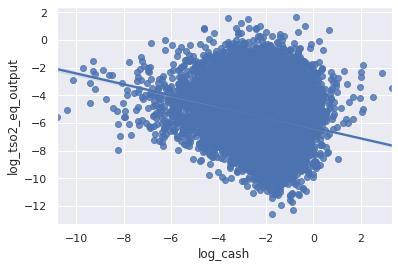

In [19]:
test = (
    df
    #.loc[lambda x: x['ind2'].isin([13])]
        .assign(
            log_cash = lambda x: np.log(x['lag_cashflow_to_tangible']),
            log_current = lambda x: np.log(x['lag_current_ratio']),
            log_eq = lambda x: np.log(x['tdso2_equip'] + 1),
            log_tso2_eq_output = lambda x: np.log(x['tso2_eq_output_1']),
            log_ttlssnl = lambda x: np.log(x['ttlssnl']),
            log_tso2 = lambda x: np.log(x['tso2'])
               )
        .reindex(columns = ['year',
                            'log_cash',
                            'log_current',
                            "log_ttlssnl",
                            'log_eq',
                            'tso2_eq_output_1',
                            'log_tso2_eq_output',
                            "constraint",
                            'polluted_d75i',
                            "log_tso2"
                           ])
    .loc[lambda x: x["tso2_eq_output_1"] > 0]
    .loc[lambda x: x["tso2_eq_output_1"] < 20]
    .sort_values(by = ['log_ttlssnl'])
)
sns.regplot(x="log_cash", y="log_tso2_eq_output", data=test)

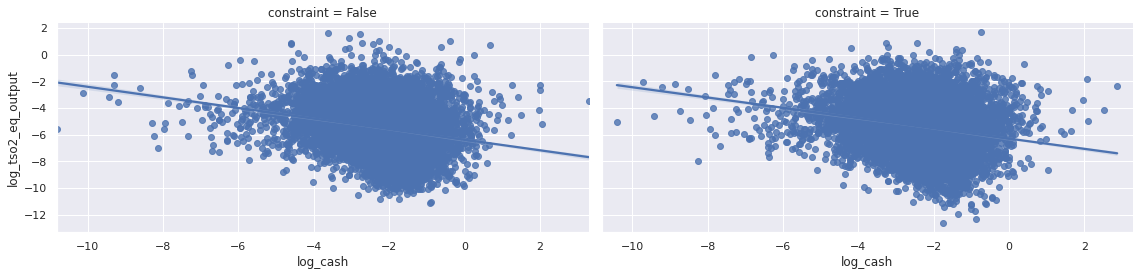

In [20]:
g = sns.FacetGrid(test, col="constraint", aspect=2, height =4)
g.map(sns.regplot, "log_cash", "log_tso2_eq_output")

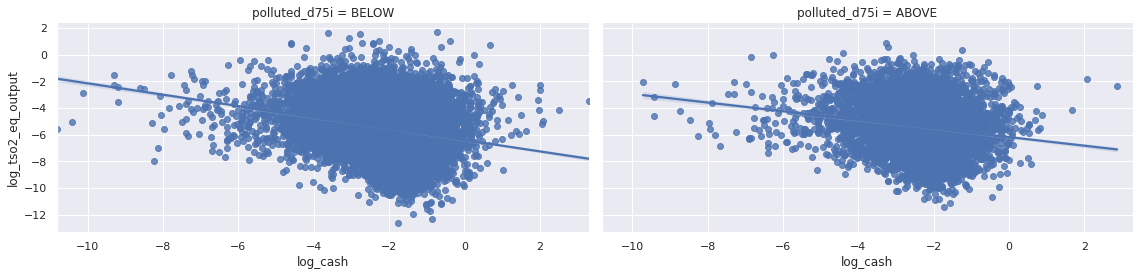

In [21]:
g = sns.FacetGrid(test, col="polluted_d75i", aspect=2, height =4)
g.map(sns.regplot, "log_cash", "log_tso2_eq_output")

<AxesSubplot:xlabel='log_current', ylabel='log_tso2_eq_output'>

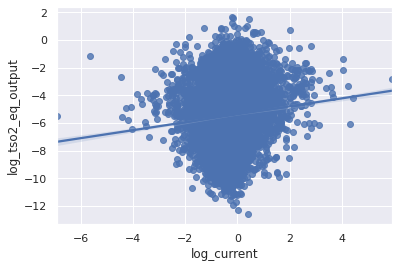

In [22]:

sns.regplot(x="log_current", y="log_tso2_eq_output", data=test)

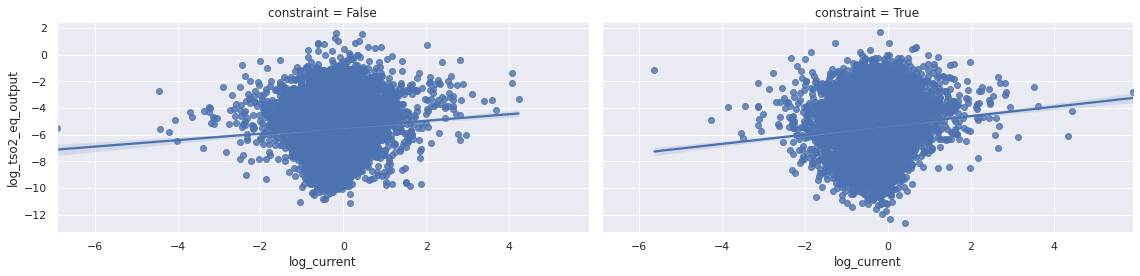

In [23]:
g = sns.FacetGrid(test, col="constraint", aspect=2, height =4)
g.map(sns.regplot, "log_current", "log_tso2_eq_output")

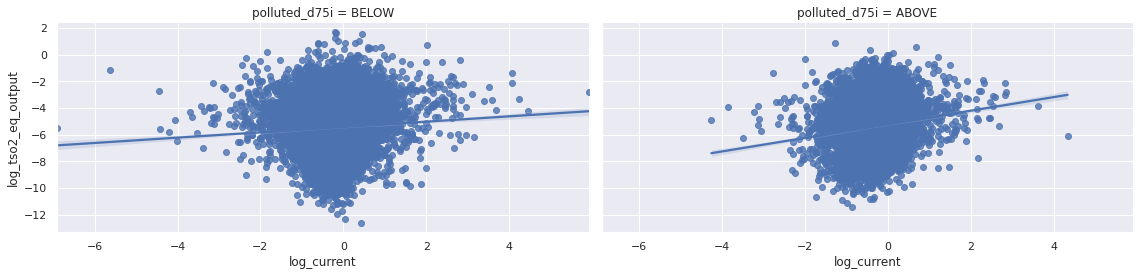

In [24]:
g = sns.FacetGrid(test, col="polluted_d75i", aspect=2, height =4)
g.map(sns.regplot, "log_current", "log_tso2_eq_output")

In [25]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [26]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 > 0)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 > 0)
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 > 0)
         ,
            exactDOF = TRUE)

t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 > 0)
         ,
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

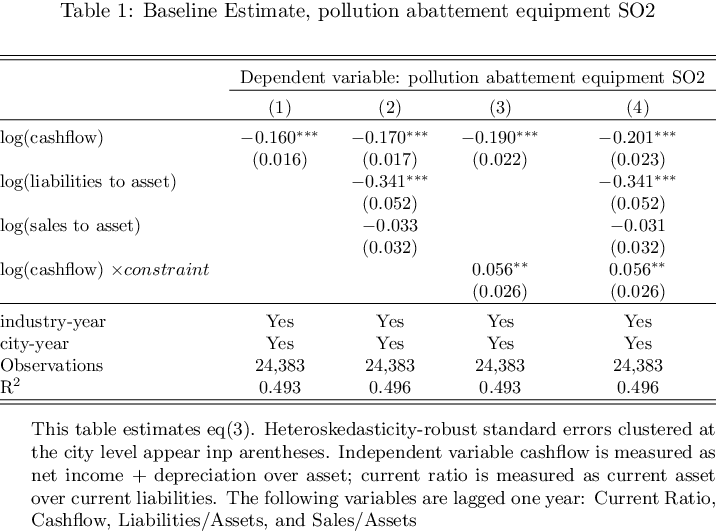

In [27]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

In [28]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [29]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0),
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

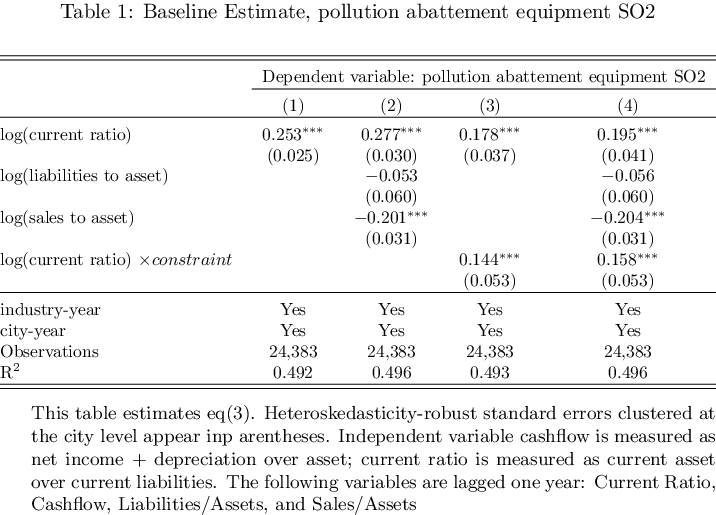

In [30]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

In [31]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [32]:
change_target <- function(table){
    ## SOE
    check_target_current_ratio <- grep("constraintTRUE:log\\(lag_current_ratio\\)", rownames(table$coef))
    check_target_cashflow <- grep("log\\(lag_cashflow_to_tangible\\):constraintTRUE", rownames(table$coef))
    ## foreign
    rownames(table$coefficients)[check_target_current_ratio] <- 'log(current_ratio):constraint'
    rownames(table$beta)[check_target_current_ratio] <- 'log(current_ratio):constraint'
    
    rownames(table$coefficients)[check_target_cashflow] <- 'log(lag_cashflow_to_tangible):constraint'
    rownames(table$beta)[check_target_cashflow] <- 'log(lag_cashflow_to_tangible):constraint'
    return (table)
    }

In [33]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)*constraint +
            log(lag_current_ratio) *constraint 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)
t_2 <- change_target(t_2)
t_3 <- felm(log(tso2_eq_output_1) ~ 
           log(lag_cashflow_to_tangible) *constraint +
            log(lag_current_ratio) *constraint +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

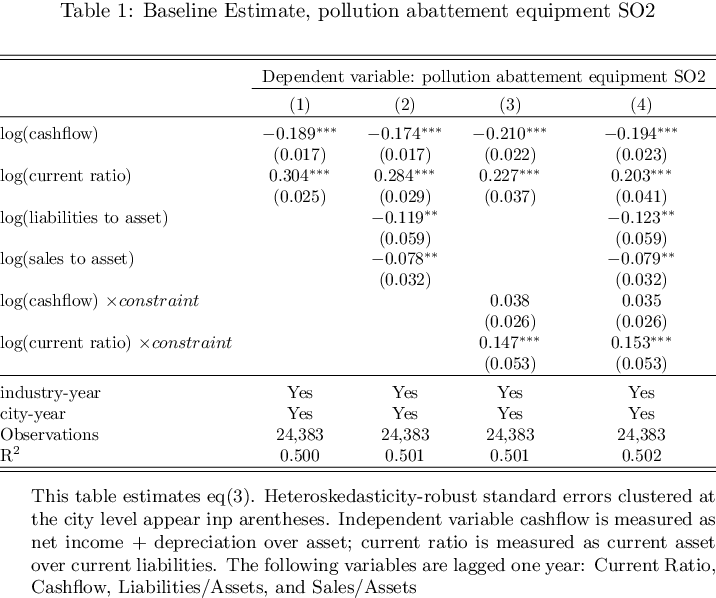

In [34]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

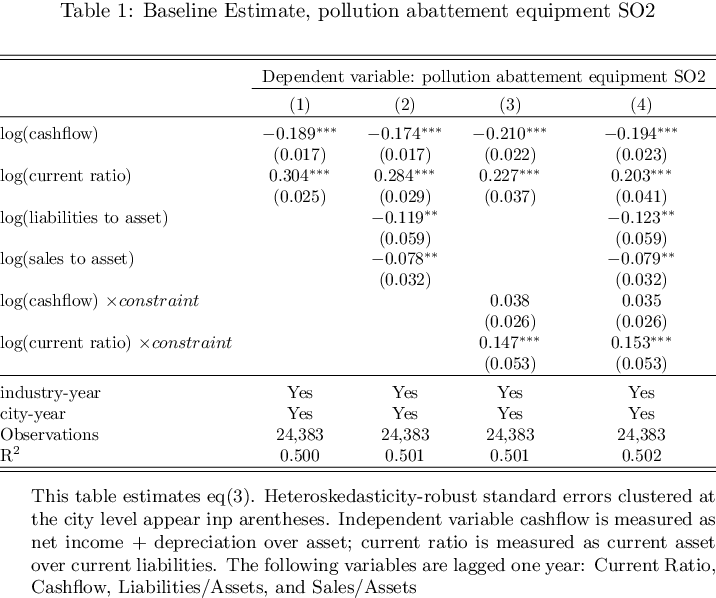

In [35]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Split sectors

In [36]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [37]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== TRUE)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== FALSE)
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== TRUE),
            exactDOF = TRUE)

t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== FALSE),
            exactDOF = TRUE)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)  +
            log(lag_current_ratio)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== TRUE)
         ,
            exactDOF = TRUE)

t_5 <- felm(log(tso2_eq_output_1) ~ 
           log(lag_cashflow_to_tangible)  +
            log(lag_current_ratio)  +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0 & constraint== FALSE),
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

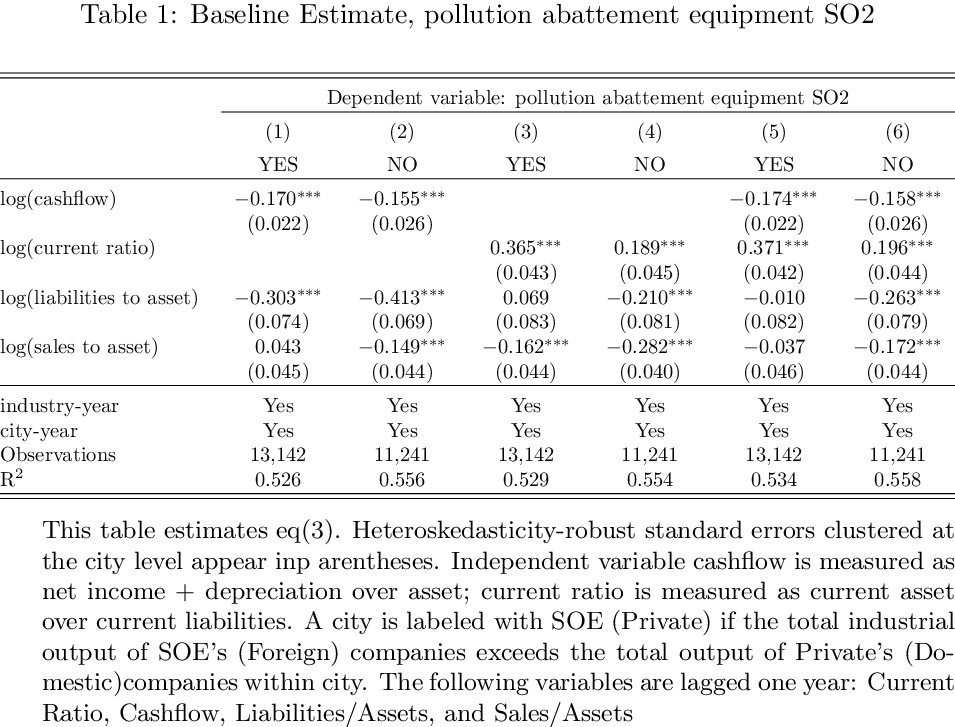

In [38]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& YES', 'NO', 'YES', 'NO',  'YES', 'NO']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

# SOE vs Private

City ownership are available for the following variables:

- output
- capital
- employment
- sales

**How is it constructed** 

* city ownership public vs private in 2002
  * Aggregate output by ownership and city
    * A given city will have SOE asset tangibility and PRIVATE asset tangibility [output, employment, capital and sales]
  * If asset tangibility SOE above Private then city is dominated by SOE
  
Notebook reference: https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/07_dominated_city_ownership.md

In [39]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, soe, geocode4_corr, indu_2,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('SOE') THEN 'SOE' ELSE 'PRIVATE' END AS soe
FROM test 
  )
  GROUP BY soe, geocode4_corr, year, indu_2
"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

Dirty code

In [40]:
import janitor

In [41]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        df_ = (
            df
            .set_index(['year','indu_2', 'soe', 'geocode4_corr'])
            .unstack(-2)
            .assign(
                soe_dominated = lambda x: x[(v, 'SOE')] > x[(v, 'PRIVATE')],
                share_soe = lambda x: x[(v, 'SOE')] / (x[(v, 'SOE')] + x[(v, 'PRIVATE')])
            )
            #.loc[lambda x: x['soe_dominated'].isin([True])]
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 'indu_2', "soe_dominated", 
             'share_soe'
             ]]
            .loc[lambda x: x['year'].isin(["2002"])]
            .drop(columns = ['year'])
            .rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_soe']> t]
            #.groupby(['soe_dominated'])
            #.agg({'share_soe':'describe'})
            .to_csv('list_city_soe_{}_{}.csv'.format(v, t), index = False)
        )

In [42]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, foreign, geocode4_corr, indu_2,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS foreign
FROM test 
  )
  GROUP BY foreign, geocode4_corr, year, indu_2

"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

In [43]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        (
            df
            .set_index(['year','indu_2', 'foreign', 'geocode4_corr'])
            .unstack(-2)
            .assign(
                for_dominated = lambda x: x[(v, 'FOREIGN')] > x[(v, 'DOMESTIC')],
                share_for = lambda x: x[(v, 'FOREIGN')] / (x[(v, 'FOREIGN')] + x[(v, 'DOMESTIC')])
            )
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 'indu_2', "for_dominated", 
             'share_for'
             ]]
            .loc[lambda x: x['year'].isin(["2002"])]
            .drop(columns = ['year'])
            .rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_for']> t]
            #.groupby(['soe_dominated'])
            #.agg({'share_soe':'describe'})
            .to_csv('list_city_for_{}_{}.csv'.format(v, t), index = False)
        )

In [44]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [45]:
%get path table
df_soe <- df_final %>% inner_join(read_csv('list_city_soe_employ_0.2.csv'))
df_priv <- df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>% filter(is.na(share_soe))
df_for <- df_final %>% inner_join(read_csv('list_city_for_employ_0.2.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_employ_0.2.csv')) %>% filter(is.na(share_for))
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_5 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_6 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_7 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3,t_4, t_5, t_6, t_7
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")


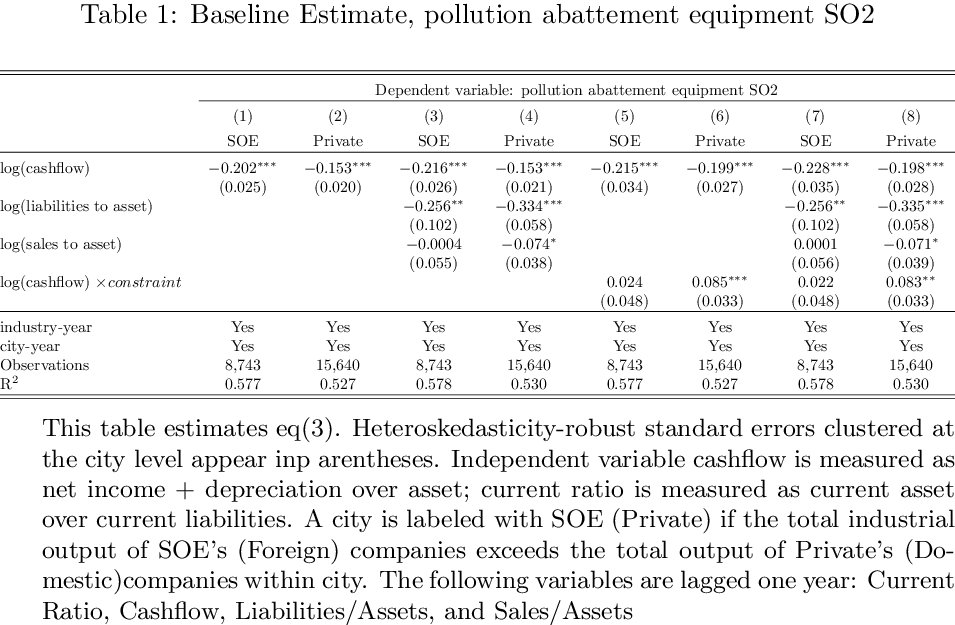

In [46]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

In [47]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [48]:
%get path table
df_soe <- df_final %>% inner_join(read_csv('list_city_soe_employ_0.2.csv'))
df_priv <- df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>% filter(is.na(share_soe))
df_for <- df_final %>% inner_join(read_csv('list_city_for_employ_0.2.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_employ_0.2.csv')) %>% filter(is.na(share_for))
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) 
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_5 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_6 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_7 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3,t_4, t_5, t_6, t_7
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")


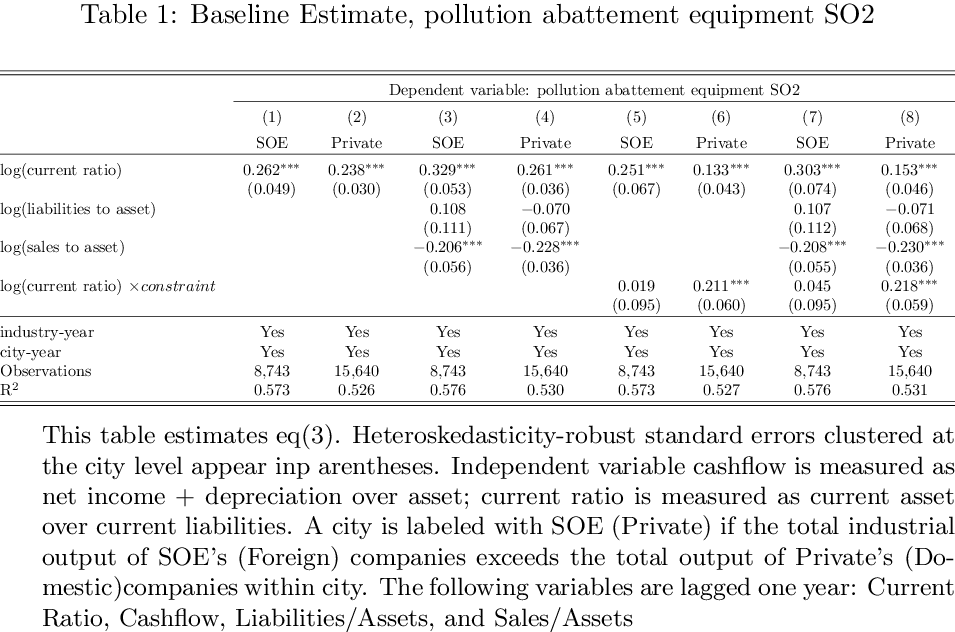

In [49]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

In [50]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [51]:
%get path table
df_soe <- df_final %>% inner_join(read_csv('list_city_soe_employ_0.2.csv'))
df_priv <- df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>% filter(is.na(share_soe))
df_for <- df_final %>% inner_join(read_csv('list_city_for_employ_0.2.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_employ_0.2.csv')) %>% filter(is.na(share_for))
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)  +
            log(lag_current_ratio)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe
         ,
            exactDOF = TRUE)
t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio)+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv
         ,
            exactDOF = TRUE)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint +
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe,
            exactDOF = TRUE)
t_4 <- change_target(t_4)
t_5 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint +
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv,
            exactDOF = TRUE)
t_5 <- change_target(t_5)
t_6 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_soe,
            exactDOF = TRUE)
t_6 <- change_target(t_6)
t_7 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_priv,
            exactDOF = TRUE)
t_7 <- change_target(t_7)
dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3,t_4, t_5, t_6, t_7
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  for_dominated = col_logical(),
  share_for = col_double()
)
Joining, by = c("geocode4_corr", "ind2")


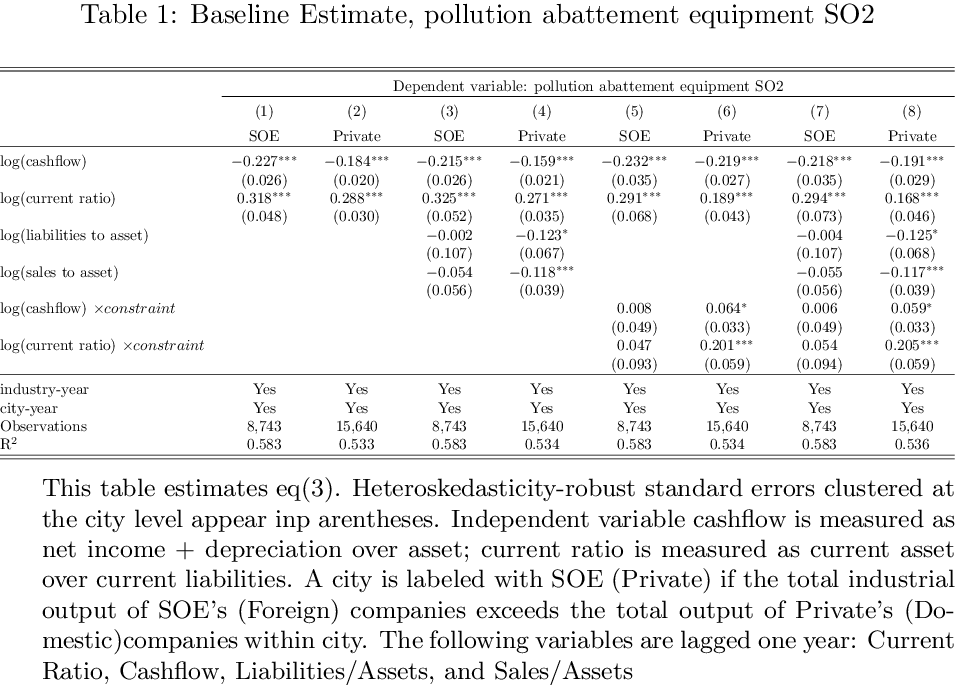

In [52]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

## Dummy

In [53]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [54]:
%get path table
#df_soe <- df_final %>% inner_join(read_csv('list_city_soe_employ_0.2.csv'))
#df_priv <- df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>% filter(is.na(share_soe))
#df_for <- df_final %>% inner_join(read_csv('list_city_for_employ_0.2.csv'))
#df_dom <- df_final %>% left_join(read_csv('list_city_for_employ_0.2.csv')) %>% filter(is.na(share_for))
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * soe_dominated
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>%
mutate(soe_dominated = replace_na(soe_dominated, FALSE))
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * soe_dominated+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>%
mutate(soe_dominated = replace_na(soe_dominated, FALSE))
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint * soe_dominated
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>%
mutate(soe_dominated = replace_na(soe_dominated, FALSE))
         ,
            exactDOF = TRUE)

t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint * soe_dominated+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_city_soe_employ_0.2.csv')) %>%
mutate(soe_dominated = replace_na(soe_dominated, FALSE))
         ,
            exactDOF = TRUE)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")
Parsed with column specification:
cols(
  geocode4_corr = col_double(),
  ind2 = col_double(),
  soe_dominated = col_logical(),
  share_soe = col_double()
)
Joining, by = c("geocode4_corr", "ind2")


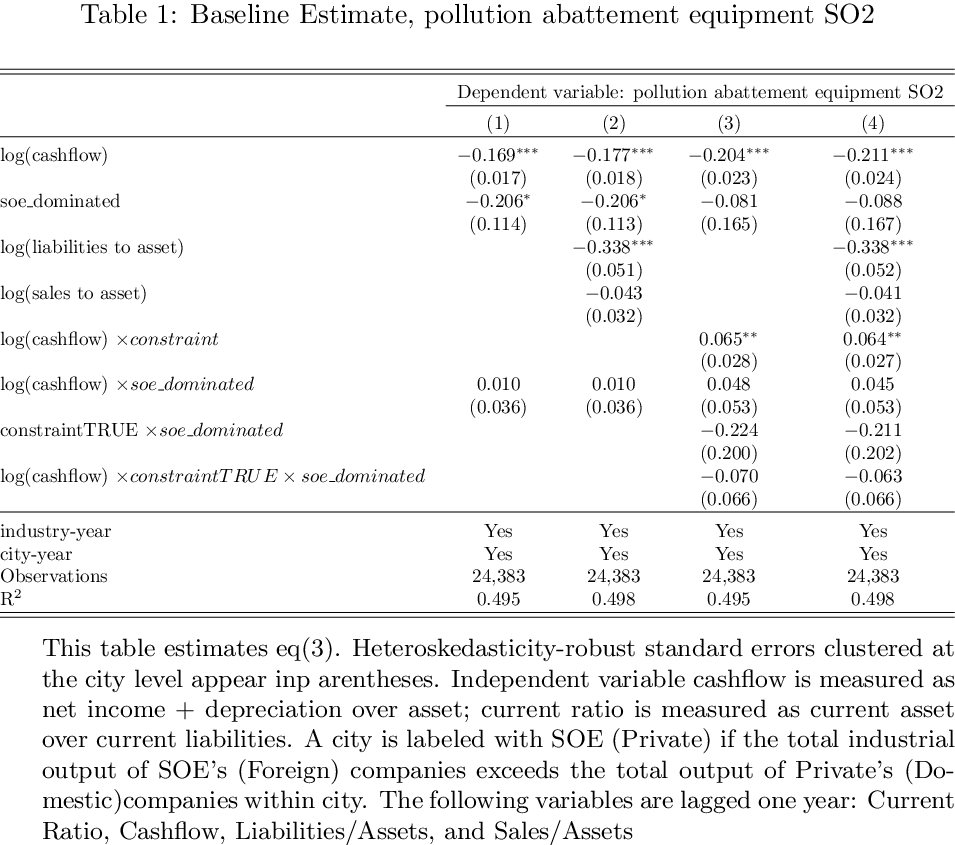

In [55]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

# Small vs large

In [56]:
query = """
SELECT year, geocode4_corr, indu_2,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
)
GROUP BY year, geocode4_corr, indu_2
"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

In [57]:
for v in ["output", "employ", "capital"]:
    for t in [0.5, 0.4, 0.3, 0.2, 0.1]:
        df_ = (
            df.groupby(["year", "indu_2"])
            .agg({"{}".format(v): "sum"})
            .reset_index()
            .loc[lambda x: x["year"].isin(["2002"])]
            .assign(
                percentile=lambda x: x[v].quantile(t),
                size=lambda x: x[v] > x["percentile"],
            )
            .drop(columns=["year", v])
            .rename(columns={"indu_2": "ind2"})
            .to_csv("list_indu_size_{}_{}.csv".format(v, t), index=False)
        )

In [58]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

## Dummy

In [59]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == TRUE)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible)  +
            log(lag_current_ratio)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == FALSE)
         ,
            exactDOF = TRUE)

t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == TRUE)
         ,
            exactDOF = TRUE)
t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) +
            log(lag_current_ratio)+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == FALSE)
         ,
            exactDOF = TRUE)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint +
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == TRUE),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
t_5 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint +
            log(lag_current_ratio) * constraint
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == FALSE),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
t_6 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == TRUE),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
t_7 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * constraint+
            log(lag_current_ratio) * constraint+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% left_join(read_csv('list_indu_size_output_0.2.csv')) %>% 
            filter(size == FALSE),
            exactDOF = TRUE)
t_7 <- change_target(t_7)
dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3,t_4, t_5, t_6, t_7
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:
cols(
  ind2 = col_double(),
  percentile = col_double(),
  size = col_logical()
)
Joining, by = "ind2"
Parsed with column specification:


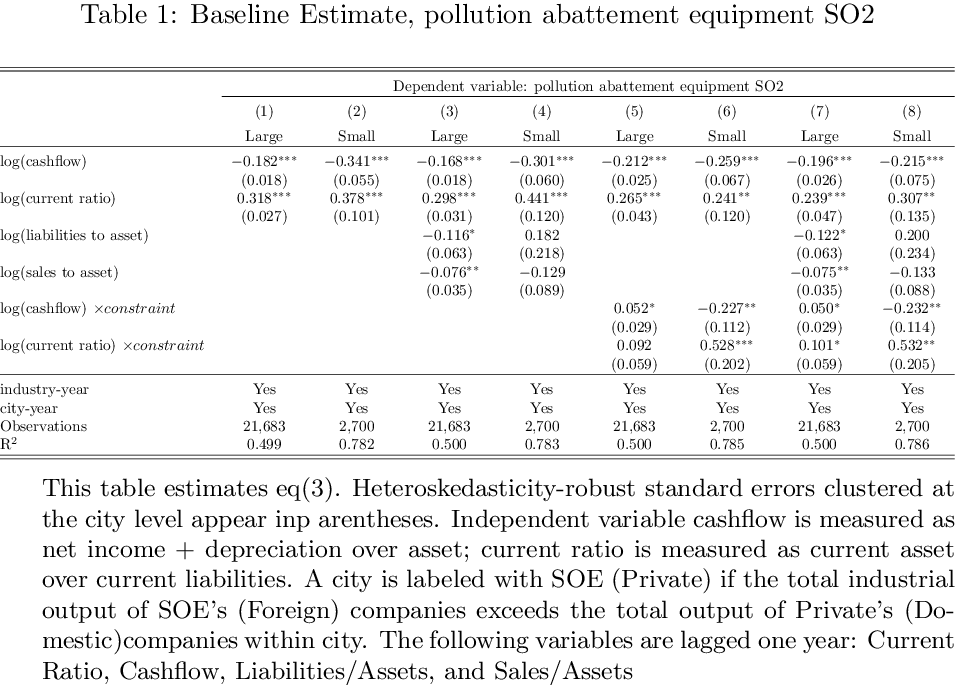

In [60]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"A city is labeled with SOE (Private) if the total industrial output of SOE's (Foreign) companies exceeds the total output of Private's (Domestic)" \
"companies within city. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." 
#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Large', 'Small', 'Large', 'Small', 'Large', 'Small', 'Large', 'Small']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
           folder = folder)

## Continuous

In [73]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [69]:
change_target <- function(table){
    ## SOE
    check_target_current_ratio <- grep("log\\(total_asset\\):log\\(lag_current_ratio\\)",
                                       rownames(table$coef))
    #check_target_cashflow <- grep("log\\(lag_cashflow_to_tangible\\):constraintTRUE", rownames(table$coef))
    ## foreign
    rownames(table$coefficients)[check_target_current_ratio] <- 'log(lag_current_ratio):log(total_asset) '
    rownames(table$beta)[check_target_current_ratio] <- 'log(lag_current_ratio):log(total_asset) '
    
    #rownames(table$coefficients)[check_target_cashflow] <- 'log(lag_cashflow_to_tangible):constraint'
    #rownames(table$beta)[check_target_cashflow] <- 'log(lag_cashflow_to_tangible):constraint'
    return (table)
    }

In [74]:
%get path table
t_0 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)

t_1 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)
t_2 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * log(total_asset) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
            )
t_2 <- change_target(t_2)
t_3 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_current_ratio) * log(total_asset) +
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)  
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final %>% filter(tso2_eq_output_1 >0)
            )
t_3 <- change_target(t_3)

t_4 <- felm(log(tso2_eq_output_1) ~ 
            log(lag_cashflow_to_tangible) * log(total_asset)+
            log(lag_current_ratio) * log(total_asset)+
            log(lag_liabilities_tot_asset) +
            log(lag_sales_tot_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr,df_final%>% filter(tso2_eq_output_1 >0)
         ,
            exactDOF = TRUE)
t_4 <- change_target(t_4)

dep <- "Dependent variable: pollution abattement equipment SO2"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="Baseline Estimate, pollution abattement equipment SO2",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

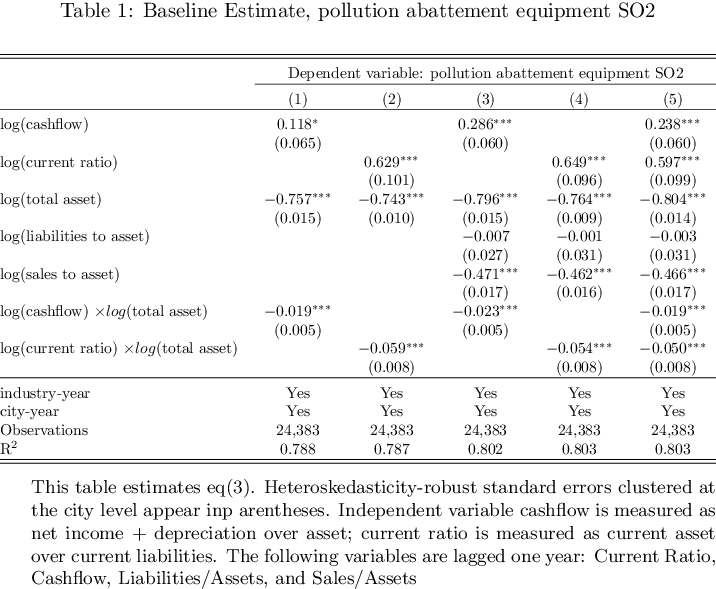

In [77]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"The following variables are lagged one year: Current Ratio, Cashflow, Liabilities/Assets, and Sales/Assets"
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

- Augmentation du cashflow finance les investissements qui réduisent les SO2, mais pas le meme résulat pour le current ratio, pourquoi? 
- Que mesure finalement la variable equipment -> est ce que les investissments dans les technos green ne sont mesurés que par la variable equipment.
- Est ce que les descriptives stats sont correctes?
- interaction: industry & industry-city
- Que mesure précisement SO2 equipment?

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [ ]:
name_json = 'parameters_ETL_pollution_credit_constraint.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
create_report.create_report(extension = "html", keep_code = False, notebookname = "07_pollution_abatement_equation.ipynb")